# <center> Text Analytics Group Assignment #1

## Brand Atrribute Extraction

In [3]:
#Importing packages
from selenium import webdriver
import pandas as pd
import nltk
from collections import Counter 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import string
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
import string
import operator
import io


#Only run if first time using NLTK
#nltk.download()

## Scrape Edmunds & Save Comments in .csv

**Forum link: https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p540**

In [ ]:
#Change path of driver
#Note: if scraper not working, check that version of driver matches version of Chrome
driver = webdriver.Chrome('C:/Users/rmead/Downloads/chromedriver_1')

In [ ]:
# Create DataFrame 
comments = pd.DataFrame(columns = ['Date','user_id','comments'])


#Srape Dates, Usernames, and Comments from most recent 100 pages (about 5000 comments)
for i in range(440,540):
    
    #address where scraping
    webpage = 'https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p' + str(i)
    driver.get(webpage)

    ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")

    comment_ids = []

    for i in ids:
        comment_ids.append(i.get_attribute('id'))

    #check if there is a blockquote (used in replies to comments) and remove
    for x in comment_ids: 
        try:
            element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]/blockquote')[0]
            driver.execute_script("""
                var element = arguments[0];
                element.parentNode.removeChild(element);
                """, element)
        except:
            pass    
    
    for x in comment_ids:
        
        #Extract dates from for each user on a page
        user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
        date = user_date.get_attribute('title')

        #Extract user ids from each user on a page
        userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text

        #Extract Message for each user on a page
        user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
            
        comment = user_message.text

                                   
        #Adding date, userid and comment for each user in a dataframe    
        comments.loc[len(comments)] = [date,userid,comment]

In [ ]:
#write to CSV 
#comments.to_csv('Edmunds_scraped2.0.csv')

## Tokenize Words in Comments & Remove Stop Words

In [6]:
#If working from CSV instead of scraping originally, read in CSV
comments = pd.read_csv('Edmunds_scraped2.0.csv',  index_col=0)

#Nulls don't play well with the tokenizer, so drop nulls
comments.dropna(inplace=True)

In [7]:
#Create new column in DataFrame of word tokens from comments
comments['Tokens'] = comments['comments'].apply(nltk.tokenize.word_tokenize)

In [8]:
#Define Stop Words & Update to include some punctuation and car(s)
stop_words = nltk.corpus.stopwords.words('english')+ list(string.punctuation)
#stop_words.update([',','.',':',"'s","n't",'?',')','(','the','...'])
#stop_words = list(stop_words)

def removeSW(word_tokens):
    filtered_sentence = []
    for w in word_tokens:
        if w.lower() not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

#Apply the removeSW function to the word tokens in the 'comments' DF
comments['Tokens'] = comments['Tokens'].apply(removeSW)

## Replace Car Models with their Corresponding Brands

In [9]:
#Read in modified 'models.csv'
#The version of this csv that is being used has removed the strange rows (ex: seat, seats)
#And it has standardized the brand names (ex: both Marcedes and Mercedes-Benz are now 'mercedes') 
models = pd.read_csv('models.csv', header=None, names=['Make','Model'])

#Create a list of all Models
models_list = models['Model'].tolist()

In [10]:
#Define a function to clean tokens & replace models with Brands
def token_cleaner(row):
    clean_tokens = []
    list_row = list(row) #Set --> List
    for word in list_row:
        word = word.lower()
        if word in models_list: #Change any models that appear to their corresponding Brands
            word = models['Make'][models['Model']==word].tolist()[0]
            if word not in clean_tokens:
                clean_tokens.append(word.lower())
        else: 
            if word not in clean_tokens: 
                clean_tokens.append(word.lower())
    clean_tokens = [x.lower() for x in clean_tokens]
    return clean_tokens

comments['Tokens'] = comments['Tokens'].apply(token_cleaner)
# print(comments['Tokens'][0:10])

## Create a Word Frequency Dictionary for Brands in Comments

In [11]:
#Initialize empty dictionary 
words_dict = dict()

#Iterate over each row of tokens and track frequency in the 'words_dict' dictionary
for row in comments['Tokens']:
    list_row = list(row) #Set --> List
    for word in row:
        word = word.lower() #Remove any capitalization
        if word in models_list: #Change any models that appear to their corresponding Brands
            word = models['Make'][models['Model']==word].tolist()[0]
                
        if word in words_dict:
            words_dict[word] += 1
        else:
            words_dict[word] = 1

## Identify top 10 Brands by Frequency 

In [12]:
top_makes = dict()
for i in words_dict: 
    if i in list(set(models['Make'])):
        top_makes[i] = words_dict[i]

k = Counter(top_makes) 
high = k.most_common(10) 

top_brands = []
for i in high:
    top_brands.append(i[0])

df_freq = pd.DataFrame(index=top_brands, columns=['Frequency'])

for i in range(0,len(high)):
    df_freq['Frequency'][i] = high[i][1]

print('\n \033[1m' + 'Brands with Highest Frequency:' + '\033[0m')    
display(df_freq)


 Brands with Highest Frequency:


,Frequency
honda,1424
ford,804
toyota,731
hyundai,565
mazda,418
nissan,390
chevrolet,350
kia,339
volkswagen,322
subaru,302


## Calculate Lift Ratios for Associations Between Brands

In [13]:
#Create a list of the unique combinations of 2 brands that appeared in the top 10 most frequent list
top_brand_combos = list(itertools.combinations(top_brands,2))

In [15]:
#Define a function that will calculate Lift
def liftCalc(word_1,word_2):
    w1freq = sum(comments.apply(lambda x: word_1 in x['Tokens'], axis=1))
    w2freq = sum(comments.apply(lambda x: word_2 in x['Tokens'], axis=1))
    bothfreq = sum(comments.apply(lambda x: word_1 in x['Tokens'] and word_2 in x['Tokens'], axis=1))
    return float(bothfreq/len(comments))/((float(w1freq)/len(comments))*(float(w2freq)/len(comments)))

In [16]:
#Initialize empty dictionary for lift values
brand_lifts = dict()

#iterate over brand combinations, calculate lift, save to dictionary
for i in range(0,len(top_brand_combos)): 
    a,b = top_brand_combos[i]
    brands = (a,b)
    lift = liftCalc(a,b)
    brand_lifts[brands] = lift

In [17]:
df_lifts = pd.DataFrame(columns=top_brands,index=top_brands)
for brand in top_brands: 
    df_lifts[brand][brand] = '-'
for brands in brand_lifts:
    a,b = brands
    df_lifts[a][b] = (brand_lifts[brands])
    df_lifts[b][a] = '-'

In [18]:
#Lift values for brand associations
df_lifts

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,kia,volkswagen,subaru
honda,-,-,-,-,-,-,-,-,-,-
ford,1.28726,-,-,-,-,-,-,-,-,-
toyota,2.19547,1.93154,-,-,-,-,-,-,-,-
hyundai,1.6647,1.75371,2.54366,-,-,-,-,-,-,-
mazda,1.68133,1.79265,2.39533,2.6142,-,-,-,-,-,-
nissan,2.00824,2.42948,3.40561,3.32159,3.29856,-,-,-,-,-
chevrolet,1.63835,2.33557,2.64664,2.84514,2.99489,3.61114,-,-,-,-
kia,1.6812,2.33828,2.49142,4.62715,3.02179,3.80364,3.73477,-,-,-
volkswagen,1.72653,2.05785,2.17874,3.42096,3.51426,3.60797,3.4018,3.5578,-,-
subaru,1.69036,2.31717,2.84177,3.06391,3.70755,3.59327,3.53288,3.55025,4.6081,-


In [19]:
d = Counter(brand_lifts)

print('\033[1m' + 'Brand Combinations With Highest Lift:' + '\033[0m')
for k, v in d.most_common(10):
    print('%s: %.6f' % (k, v))

Brand Combinations With Highest Lift:
('hyundai', 'kia'): 4.627154
('volkswagen', 'subaru'): 4.608099
('nissan', 'kia'): 3.803638
('chevrolet', 'kia'): 3.734775
('mazda', 'subaru'): 3.707548
('nissan', 'chevrolet'): 3.611143
('nissan', 'volkswagen'): 3.607971
('nissan', 'subaru'): 3.593267
('kia', 'volkswagen'): 3.557797
('kia', 'subaru'): 3.550245


In [20]:
print('\033[1m' + 'Brand Combinations With Lowest Lift:' + '\033[0m')
for k, v in d.most_common()[-11:-1]:
    print('%s: %.6f' % (k, v))

Brand Combinations With Lowest Lift:
('honda', 'nissan'): 2.008240
('ford', 'toyota'): 1.931539
('ford', 'mazda'): 1.792649
('ford', 'hyundai'): 1.753709
('honda', 'volkswagen'): 1.726527
('honda', 'subaru'): 1.690355
('honda', 'mazda'): 1.681326
('honda', 'kia'): 1.681203
('honda', 'hyundai'): 1.664700
('honda', 'chevrolet'): 1.638355


## Create MDS Map for Top 10 Brands

In [21]:
top_brand_lifts = pd.DataFrame(columns=top_brands,index=top_brands)

In [22]:
for brands in brand_lifts:
    a,b = brands
    top_brand_lifts[a][b] = (1/brand_lifts[brands])
    top_brand_lifts[b][a] = (1/brand_lifts[brands])

In [23]:
for brand in top_brands: 
    top_brand_lifts[brand][brand] = 0

In [24]:
top_brand_lifts

,honda,ford,toyota,hyundai,mazda,nissan,chevrolet,kia,volkswagen,subaru
honda,0,0.776841,0.455483,0.600709,0.594769,0.497949,0.610368,0.594812,0.579197,0.591592
ford,0.776841,0,0.517722,0.57022,0.557834,0.411611,0.428162,0.427665,0.485944,0.431561
toyota,0.455483,0.517722,0,0.393135,0.417479,0.293633,0.377837,0.401378,0.45898,0.351894
hyundai,0.600709,0.57022,0.393135,0,0.382526,0.30106,0.351476,0.216116,0.292316,0.32638
mazda,0.594769,0.557834,0.417479,0.382526,0,0.303162,0.333902,0.330929,0.284555,0.26972
nissan,0.497949,0.411611,0.293633,0.30106,0.303162,0,0.276921,0.262906,0.277164,0.278298
chevrolet,0.610368,0.428162,0.377837,0.351476,0.333902,0.276921,0,0.267754,0.293962,0.283055
kia,0.594812,0.427665,0.401378,0.216116,0.330929,0.262906,0.267754,0,0.281073,0.281671
volkswagen,0.579197,0.485944,0.45898,0.292316,0.284555,0.277164,0.293962,0.281073,0,0.217009
subaru,0.591592,0.431561,0.351894,0.32638,0.26972,0.278298,0.283055,0.281671,0.217009,0


In [25]:
mds = manifold.MDS(dissimilarity='euclidean')
mds_fit = mds.fit(top_brand_lifts)
coords = mds.fit_transform(top_brand_lifts)

Text(0.5, 1.0, 'Multidimensional Scaling: Top 10 Brands \n (Euclidean Distances = 1 / lift)')

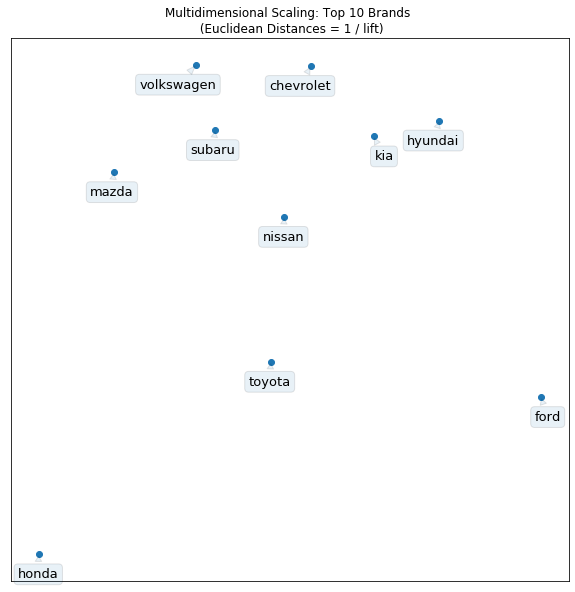

In [26]:
x,y = coords.T

plt.figure(figsize=(10, 10))
plt.scatter(x,y)

for i, txt in enumerate(top_brands):
    plt.annotate(txt, (x[i], y[i]), xycoords='data',
             xytext=(20, -20), textcoords='offset points',
             size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1))
    
plt.yticks([])
plt.xticks([])
plt.title('Multidimensional Scaling: Top 10 Brands \n (Euclidean Distances = 1 / lift)')


## Advice and Insights

### Task B : What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)?  

The brands with the highest common lift are Hyundai and Kia with the _**lift value equal to 4.29**_, which turns out to be the highest between any 2 combinations among the top 10 brands. The frequency of occurrence of Hyundai is 887 and that of Kia is 522 among the total posts and comments scraped.

Digging deeper to understand the co-occurrence of these brands in comments, we realized that Kia and Hyundai, both belong to the same parent company. Hyundai and Kia are both leading car manufacturers from South Korea. Hyundai Motors bought a 51% stake of Kia Motors in 1998 when the latter declared bankruptcy. 

The numbers suggest that customers closely associate the two car brands together. Brand managers of the two sister companies must focus on _**differentiating the customer sentiment**_ associated with each brand. In the long run, this could lead to brand cannibalism where the brands would be competing for market share. The management must focus more on driving advertising and marketing campaigns to spread awareness about each of these brands in a unique manner. 

Another way to improve brand differentiation is by _**focusing on product features**_ specifically intended for targeted customer segments. This would not only change customer perception but also help carve out two niche markets for each of these brands, which the parent company would benefit from. Hyundai is typically known for its reasonably well-sized cars with luxury interiors. They could build on top of existing features making their cars attractive for the older generation who are more focused on quality and comfort. Kia is known for its sporty design, yet affordable prices meant for the younger generation. _**Driving digital marketing campaigns, rallies and concerts for Kia customers would help establish brand loyalty among the millennials and Gen-Z.**_

## Measure & Consolidate Frequently Occuring Attributes

In [29]:
#Initialize empty dictionary 
all_words_dict = dict()

#Iterate over each row of tokens and track frequency in the 'words_dict' dictionary
for row in comments['Tokens']:
    list_row = list(row) #Set --> List
    for word in row:
        word = word.lower() #Remove any capitalization
        if word in all_words_dict:
            all_words_dict[word] += 1
        else:
            all_words_dict[word] = 1

In [30]:
# k = Counter(all_words_dict) 
# k.most_common(200) 
# Based on the first 200 words by frequency, the most frequently mentioned attributes are:
freq_attrib = ['ride','transmission','mpg','miles','gas','fuel',
               'mileage','engine','big','little','size','small',
               'price','deal','money','cost','msrp','cheap','warranty',
               'turbo','power','sport','speed','hp','interior','seat',
               'seats','comfortable','room','epa','emissions','fun',
               'performance','tires','wheels','wheel','awd','design',
               'visibility']
new_freq = pd.DataFrame(columns=top_brands, index=freq_attrib)
#new_freq

In [25]:
#Run lift calculations for attributes in freq_attrib to decide which attribtes to map together. 
#This was used to create attribute_map.csv
#This code was commented out because it is slow to run

# for brand in top_brands:
#     for attrib in freq_attrib:
#         try:
#             new_freq[brand][attrib] = liftCalc(brand,attrib)
#         except: 
#             new_freq[brand][attrib] = 'N/A'

# Create table of lift calculations of attributes with brands
# new_freq

In [31]:
#Read in CSV of attributes to map
attribute_map = pd.read_csv('attribute_map.csv', header=None)
attribute_map.columns =['key','attribute']
attributes = set(attribute_map['attribute'].to_list())
keys = set(attribute_map['key'].to_list())

In [32]:
def attribute_cleaner(row):
    clean_tokens = []
    for word in row:
        if word in keys: 
            word = attribute_map['attribute'][attribute_map['key']==word].tolist()[0]
            clean_tokens.append(word)
        else: 
            clean_tokens.append(word)
    return clean_tokens

comments['Tokens'] = comments['Tokens'].apply(attribute_cleaner)

In [33]:
att_lift = pd.DataFrame(columns=top_brands, index=attributes)

for brand in top_brands:
    for attrib in attributes:
        try:
            att_lift[brand][attrib] = liftCalc(brand,attrib)
        except: 
            att_lift[brand][attrib] = 'N/A'

#att_lift is a DF of all the attributes which were considered, not just the top 5
#att_lift

In [34]:
#write final DataFrame to csv for data file with all brands and attributes mapped
#comments.to_csv('Edmunds_After_Replacements.csv')

## Top 5 Attributes &  Top 5 Brands Lift Values

In [35]:
#Top 5 Attributes were Chosen by Frequency
top5attributes = ['fuel economy','performance','interior','financing','comfort']
att_lift2 = att_lift.loc[top5attributes][top_brands[0:5]]
att_lift2.style.apply(lambda x: ["background: yellow" if v > 1.8 else "" for v in x], axis = 1)

,honda,ford,toyota,hyundai,mazda
fuel economy,1.34832,1.31546,1.19085,1.58393,1.28457
performance,1.4588,1.42174,1.19535,1.22556,1.89322
interior,1.65112,1.37617,1.81924,1.8265,1.78163
financing,1.49144,1.17208,1.53926,1.81724,1.21134
comfort,1.44976,1.48526,2.0489,2.18519,1.74314


### Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive). 

### Product Managers
##### Honda:
Honda has a low lift for “comfort” and “interior” compared to a Toyota or a Hyundai. All three brands compete in the space in the market, but our analysis shows that customers perceive Toyota and Hyundai sedans  as confortable cars having pleasant interiors. Product managers for Honda's upcoming model years should **focus on improving the quality of their models' interiors**, paying particular attention to features like more leg room, quiet cabins, and sufficient head room for tall passengers. Addressing buyers' lack of enthusiasm about interiors and comfort will help Honda to be more competitive and bring them on par with their competitors.

##### Ford:
Ford was the second most frequently mentioned maker in the midsize sedans forum, but it scores low on every attribute association compared to the other top brands. This does not mean that people strongly dislike Ford cars, but instead that there is ambivalence and a lack of association with Ford and any given attribute. It seems to suggest that **public perception of Ford cars is somewhat bland**. In order to increase passion for Ford cars, a product manager at Ford, can afford to **take more risks** in their approach to building future models, **innovating their design and improving performance and comfort**. In a highly competitive market, if Ford wants to maintain its popularity it will have to generate more enthusiasm in future buyers. Otherwise, there is a high probability that customers could move on to purchase other brands that are highly associated with the attributes that they desire.

### Marketing/Advertising Managers
##### Mazda: 
Mazda stands out above the competition in its association with performance in discussions on Edmunds. When people mention Mazda in their posts, they are more likely to also use words like **“power”, “speed”, “engine” and “turbo,”** among others. Mazda can capitalize on this association by advertising to this strength. People already perceive Mazda cars as sporty and fun to drive, so they should exploit this public opinion by **targeting their advertising to young potential buyers and older mid-life-crisis buyers**. Buyers looking for high performance cars may not place as high importance on fuel economy, so Mazda should not worry about slightly lower lift values for fuel economy. However, if it has cars with fuel economy that is similar to other makers, it might be able to **gain market share by advertising that it is able to maintain top performance and fuel economy**. 

##### Toyota:
Toyota has a low lift value in “fuel economy” compared to a Hyundai, and the lowest "fuel economy" lift of any brand in the top 5. This means that people don’t strongly associate Toyota with fuel economy. This is does not reflect differences in these brands' products: in reality, gas mileage for Hyundai and Toyota models are similar as per car specifications. For example, the 2019 Toyota Corolla gets 32 combined miles per gallon (MPG), while the 2019 Hyundai Elantra gets only 28 combined MPG. **The Toyota car is actually superior to Hyundai in MPG**, but this advantage is not perceived by the end customer. Therefore, Marketing and Advertising managers for Toyota should focus in their upcoming campaigns to **project a fuel-efficient image of Toyota**.

## Define "Aspirational" Words and Find "Aspirational" Brands 

In [37]:
comments = pd.read_csv('Edmunds_scraped2.0.csv',  index_col=0)
comments.dropna(inplace=True)
comments['Tokens2'] = comments['comments'].apply(nltk.tokenize.word_tokenize)

In [38]:
def lower_func(row):
    list_row = list(row)
    token=[]
    for word in list_row:
        word=word.lower()
        if word in models_list: #Change any models that appear to their corresponding Brands
            word = models['Make'][models['Model']==word].tolist()[0]
            if word not in token:
                token.append(word) 
        else: 
                token.append(word) 
    return token

comments['Tokens2'] = comments['Tokens2'].apply(lower_func)

In [39]:
def attach_together(token_list):
    r=''
    for each in token_list:
        r=r+'' + each + ' '
    return r

comments['Attached_Tokens'] = comments['Tokens2'].apply(attach_together)

**The aspirational phrases were identified by reading a bunch of comments from the ones we scrapped to get an idea of how people were displaying aspiration (and some intuition). We compiled the below 'aspirations' list using the most common phrases that we found.**

**Each aspirational phrase was replaced in the comments with a phrase("aspirations_find_out"). The most aspirational brand was the one that had the highest lift value with this phrase.**

In [40]:
aspirations=['desire to','desirable','fancy car','eager to buy','would like to buy','love to have','dream car','really want','future car','dream of',"cant wait to buy",'would love to buy','wish to buy','want to buy','aspire to','future car','thinking to buy','love to buy','want to own','love to own','like to own','have to own','nice to own','nice to buy','have to buy','would love to buy','would like to buy','wish to own','looking to buy','looking forward to buy']
unique_brands=list(set(models.Make.values))

In [41]:
#Define a function that will calculate Lift based on new tokens
def liftCalc_aspiration(word_1,word_2):
  
    w1freq = sum(comments.apply(lambda x: word_1 in x.Attached_Tokens_Tokenized, axis=1))
    w2freq = sum(comments.apply(lambda x: word_2 in x.Attached_Tokens_Tokenized, axis=1))
    bothfreq = sum(comments.apply(lambda x: word_1 in x.Attached_Tokens_Tokenized and word_2 in x.Attached_Tokens_Tokenized, axis=1))
    try:
        return float(bothfreq/len(comments))/((float(w1freq)/len(comments))*(float(w2freq)/len(comments)))
    except:
        return 0

In [42]:
def find_aspirations(each_at):
  #print(each_at)

    for each_aspiration in aspirations:
        if each_aspiration in each_at:
            for brand in unique_brands:
                if brand in each_at:
                    each_at=each_at.replace(each_aspiration,'aspirations_find_out')          
                    #print(brand,each_aspiration) 
    return each_at

comments.Attached_Tokens=comments.Attached_Tokens.apply(find_aspirations)
comments['Attached_Tokens_Tokenized']=comments.Attached_Tokens.apply(nltk.tokenize.word_tokenize)

## "Most Aspirational" Brands and Lift Values

In [43]:
d = {} 
for brand in unique_brands:
    lift=liftCalc_aspiration(brand,'aspirations_find_out')
    if lift>0:
        d[brand]=lift

sorted_d= sorted(d.items(), key=operator.itemgetter(1),reverse=True)

df_aspiration = pd.DataFrame(sorted_d,columns=['Brand','Lift'])

print('\n \033[1m' + 'BMW is the "Most Aspirational" Brand ' + '\033[0m')
print('\n Brands and Lift Values:')
display(df_aspiration)


 BMW is the "Most Aspirational" Brand 

 Brands and Lift Values:


,Brand,Lift
0,bmw,3.486695
1,audi,2.985012
2,hyundai,2.937463
3,toyota,2.554207
4,dodge,2.499498
5,mazda,2.481559
6,acura,2.412306
7,nissan,2.127778
8,subaru,2.060844
9,honda,2.039618


### Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

BMW appears to be the most aspirational car brand in the mid-size sedan segment followed closely by its German counterpart Audi. _**BMW has a lift value of 3.48 and Audi has a lift value of 2.98 in association with aspirational customer sentiment. Next in the list are Hyundai and Toyota, leading Asian car manufacturers.**_ Hyundai and Toyota's appearance so high on the list was surprising, but may confirm the popular belief that American car buyers are not very brand conscious.

The low co-occurrence of other brands and aspirational phrases reflects their market positions as reliable economy cars, not luxury mid-sized sedans which people "aspire to own". Even if they offer higher-end product features, _**the brand image for BMW and Audi are superior from customers' perspectives**_.
Honda, Kia, Ford, Volkswagen appear further down in the list. These brands are considered family-oriented cars with a strong focus on safety and comfort, while being affordable. 

We have included phrases such as **‘wish to own’, ‘wish to buy’, ‘want to buy’, ’looking to buy’, ‘desire to buy’, ‘dream car’, ‘have to own’, ‘future car’, ‘want to own’, ‘desirable’**, etc. as aspirational words. These words were picked after ensuring that a sample of comments retrieved for a given phrase displayed strong aspiration or wistful intent to buy a car of a certain make or model.
